In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# car racing v2 environment

In [3]:
env = gym.make('CarRacing-v2', continuous=False)
print("observation space:", env.observation_space)
print("Action space:", env.action_space)

observation space: Box(0, 255, (96, 96, 3), uint8)
Action space: Discrete(5)


In [4]:
# initial state

In [5]:
s, info = env.reset()
print(s.shape)

(96, 96, 3)


In [6]:
info

{}

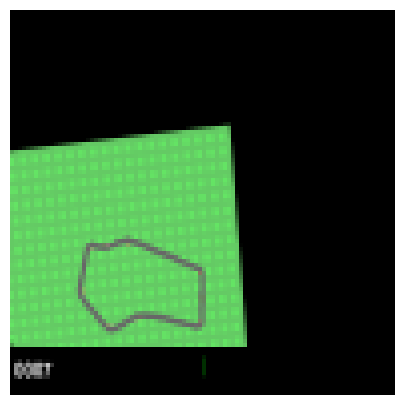

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(s)
plt.axis('off')
plt.show()

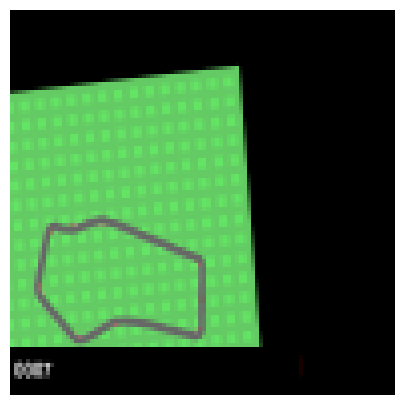

In [8]:
# no_op action
import matplotlib.animation as animation
from IPython.display import HTML

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0) # 0th action is the no_op action
    frames.append(s)

#create animation
fig = plt.figure(figsize=(5,5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

we have to know that we are given only one current game frame for each step. This observation setting cannot satisfy the Markov property. We cannot guess if the car is moving forward or backward from only one frame, which means we cannot predict the next frame for given the current frame. Thus, we need to stack the previous $k = 4$ 
 frames.

#### Pre-processing
From DQN paper, <br>
The raw frames are preprocessed by first converting their RGB representation to gray-scale <br>
… <br>
The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area<br>
… <br>
For the experiments in this paper, the function $\phi$
 from algorithm 1 applies this preprocessing to the last 4 frames of a history and stacks them to produce the input to the Q-function <br>
… <br>
we also use a simple frame-skipping technique [3]. More precisely, the agent sees and selects actions on every kth frame instead of every frame, and its last action is repeated on skipped frames.

In [9]:
import cv2

In [10]:
def preprocess(img):
    img = img[:84, 6:90] # car racing v2 specific cropping
    # img = cv2.resize(img, dsize=(84,84)) # alternatively, use rescaling
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255.0
    return img

In [11]:
# change the initial setting (reset) and observations (step)

In [18]:
class ImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=4, stack_frames=4, initial_no_op=50, **kwargs):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        # reset the original environment
        s, info = self.env.reset()

        # do nothing for the next 'self.initial_no_op' steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # convert a frame to 84x84 grayscale
        s = preprocess(s)

        # the initial obsetvation is simply a copy of the frame s
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1)) #[4,84,84]
        return self.stacked_state, info

    def step(self, action):
        # take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # convert a frame to 84x84 grayscale 
        s = preprocess(s)

        # push the current frame 's' at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis = 0)

        return self.stacked_state, reward, terminated, truncated, info
        

In [19]:
# create our environment

In [21]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

In [23]:
s, _ = env.reset()
print("The shape of an observation:", s.shape)

The shape of an observation: (4, 84, 84)


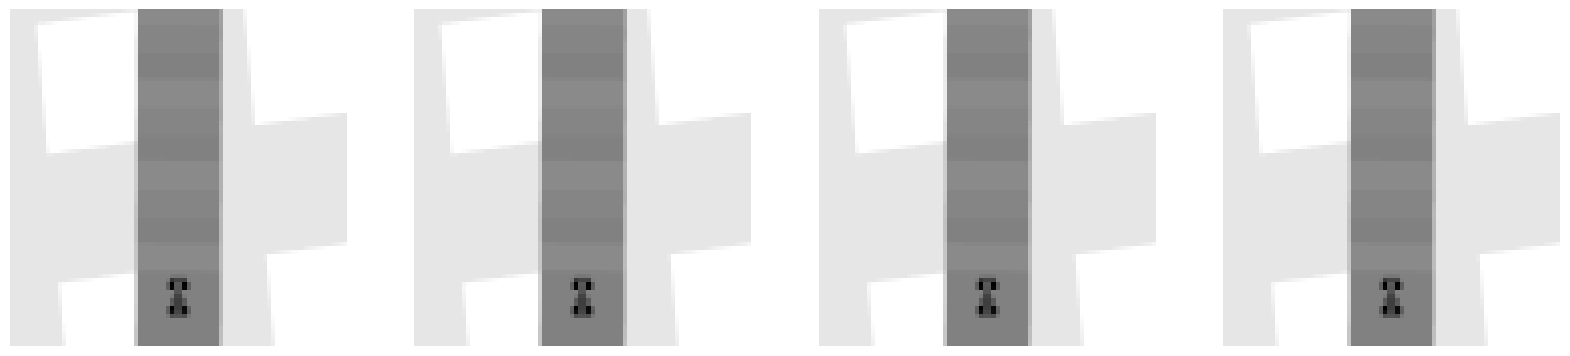

In [24]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [25]:
# a gas action.

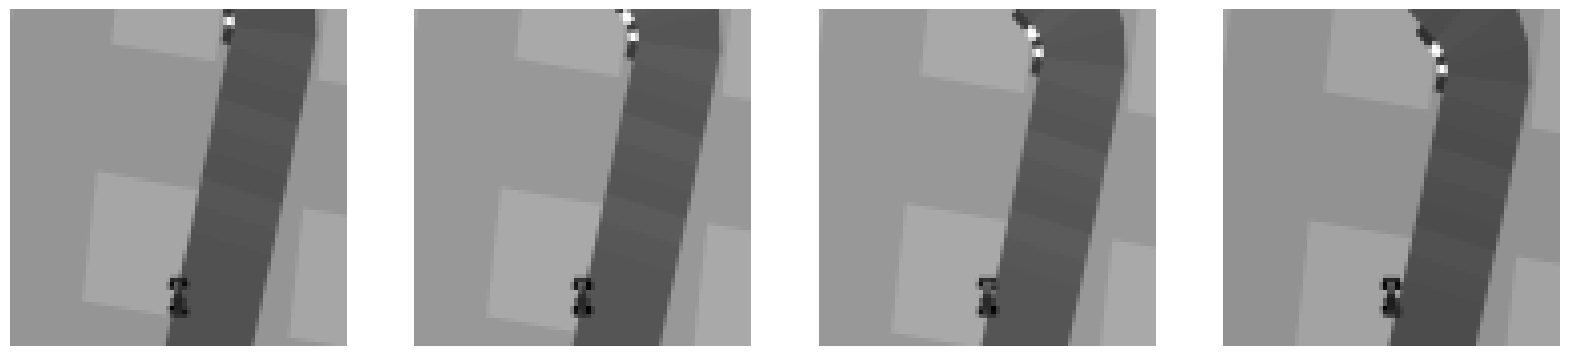

In [33]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3) #3rd action is gas action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

Reference: https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html